In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input, Concatenate, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [117]:
df = pd.read_csv("plant1_final.csv")

In [118]:
# Cyclical encoding of timestamps

df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['hour'] = df['DATE_TIME'].dt.hour
df['minute'] = df['DATE_TIME'].dt.minute
df['time_of_day'] = df['hour'] + df['minute']/60
df['hour_sin'] = np.sin(2 * np.pi * df['time_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time_of_day'] / 24)
df['day_of_year'] = df['DATE_TIME'].dt.dayofyear
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Drop intermediate columns
df = df.drop(columns=['hour', 'minute', 'time_of_day', 'day_of_year'])

In [119]:
# Select features and target
features = [
    'DC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
]
target = 'AC_POWER'

# Scaling
# Use two separate scalers for features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scales the feature and target columns to a range between 0 and 1
df[features] = scaler_features.fit_transform(df[features])
df[target] = scaler_target.fit_transform(df[[target]])

# Sequences Generation
# This function transforms the time-series data into input-output pairs for the LSTM.
def create_sequences(data, features, target, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:(i + sequence_length)].values)
        y.append(data[target].iloc[i + sequence_length])
    return np.array(X), np.array(y)

all_X = []
all_y = []
inverter_keys = df['SOURCE_KEY'].unique()

# Iterate through each unique solar inverter (SOURCE_KEY) and creates sequences for it separately.
for key in inverter_keys:
    inverter_df = df[df['SOURCE_KEY'] == key]
    X_inverter, y_inverter = create_sequences(inverter_df, features, target)
    if len(X_inverter) > 0:
        all_X.append(X_inverter)
        all_y.append(y_inverter)

# Concatenate all sequences
# Combines the sequences from all inverters into single NumPy arrays X and y.
X = np.concatenate(all_X)
y = np.concatenate(all_y)

# Data chronological split
# The data is split chronologically into training (70%), validation (10%), and testing (20%) sets.
train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))

# Split the data
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"Shape of training data (X_train): {X_train.shape}")
print(f"Shape of validation data (X_val): {X_val.shape}")
print(f"Shape of testing data (X_test): {X_test.shape}")

Shape of training data (X_train): (47772, 24, 8)
Shape of validation data (X_val): (6824, 24, 8)
Shape of testing data (X_test): (13650, 24, 8)


In [120]:
# Sequential creates the model layer by layer
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)), # 32 neurons in the first layer
    Dropout(0.4),
    LSTM(16, return_sequences=False), # 16 neurons in the second layer
    Dropout(0.3),
    Dense(16, activation='relu',kernel_regularizer=l2(0.001)), # A standard fully connected layer with 16 neurons and a ReLU activation function to introduce non-linearity.
    Dense(1) # The final output layer with a single neuron to produce the single predicted 
])

optimizer = Adam(learning_rate=0.001) # Gradient descent optimization algorithm

model.compile(optimizer= optimizer, 
              loss= MeanSquaredError(),
              metrics=[RootMeanSquaredError(name='rmse')]) # configuration of the model for training


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True) # trianing will stop if the loss function won't improve for 10 epochs

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau( # Automatically reduces the LR during trainign when the model stops improving
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint('best_solar_model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

history = model.fit(X_train, y_train,
                    epochs= 100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)

c:\Users\lucag\Desktop\DTE_ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0188 - rmse: 0.1055 - val_loss: 0.0095 - val_rmse: 0.0856
Epoch 2/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 0.0096 - rmse: 0.0905 - val_loss: 0.0078 - val_rmse: 0.0822
Epoch 3/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 0.0085 - rmse: 0.0868 - val_loss: 0.0075 - val_rmse: 0.0822
Epoch 4/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 0.0079 - rmse: 0.0846 - val_loss: 0.0066 - val_rmse: 0.0771
Epoch 5/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 0.0075 - rmse: 0.0830 - val_loss: 0.0064 - val_rmse: 0.0756
Epoch 6/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - loss: 0.0073 - rmse: 0.0822 - val_loss: 0.0065 - val_rmse: 0.0776
Epoch 7/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - loss: 0.0071 - rmse: 0.0814 - val_loss: 0.0061 - val_rmse: 0.0746
Epoch 8/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 0.0070 - rmse: 0.0810 - val_loss: 0.0063 - val_rmse: 0.0763


In [121]:
# After training, the model's performance is evaluated on all three data splits using standard regression metrics.
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

# This crucial step converts the scaled predictions and the scaled actual values back to their original AC_POWER units, making the metrics interpretable.

# Training Set
y_pred_train_scaled = model.predict(X_train)
y_pred_train = scaler_target.inverse_transform(y_pred_train_scaled)
y_train_inversed = scaler_target.inverse_transform(y_train.reshape(-1, 1))

# Validation Set
y_pred_val_scaled = model.predict(X_val)
y_pred_val = scaler_target.inverse_transform(y_pred_val_scaled)
y_val_inversed = scaler_target.inverse_transform(y_val.reshape(-1, 1))

# Test Set
y_pred_test_scaled = model.predict(X_test)
y_pred_test = scaler_target.inverse_transform(y_pred_test_scaled)
y_test_inversed = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calclulate metrics
train_metrics = calculate_metrics(y_train_inversed, y_pred_train)
val_metrics = calculate_metrics(y_val_inversed, y_pred_val)
test_metrics = calculate_metrics(y_test_inversed, y_pred_test)

print(f"Training Metrics:   {train_metrics}")
print(f"Validation Metrics: {val_metrics}")
print(f"Test Metrics:       {test_metrics}")

1493/1493 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
427/427 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Training Metrics:   {'MSE': 5725.621544594984, 'RMSE': np.float64(75.66783692292904), 'MAE': 40.07044701189073, 'R²': 0.9632373820294946}
Validation Metrics: {'MSE': 6002.805944127996, 'RMSE': np.float64(77.47777709852029), 'MAE': 40.596981303503206, 'R²': 0.96219249742325}
Test Metrics:       {'MSE': 6124.464252407668, 'RMSE': np.float64(78.25895637182794), 'MAE': 40.52159641229957, 'R²': 0.9606335344191204}


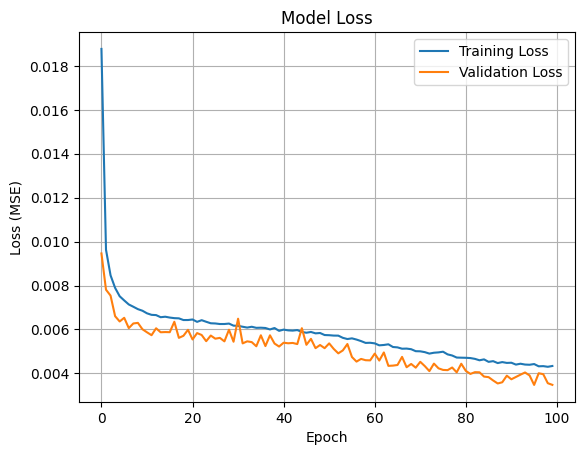

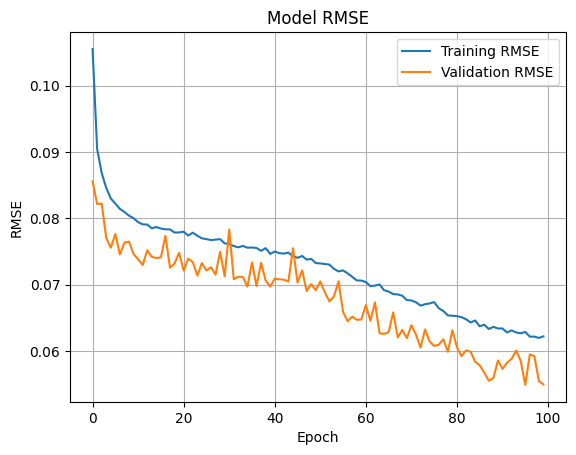

C:\Users\lucag\AppData\Local\Temp\ipykernel_2252\3161705019.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


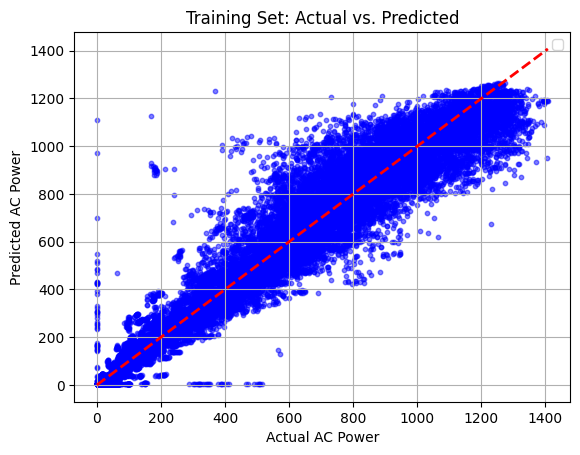

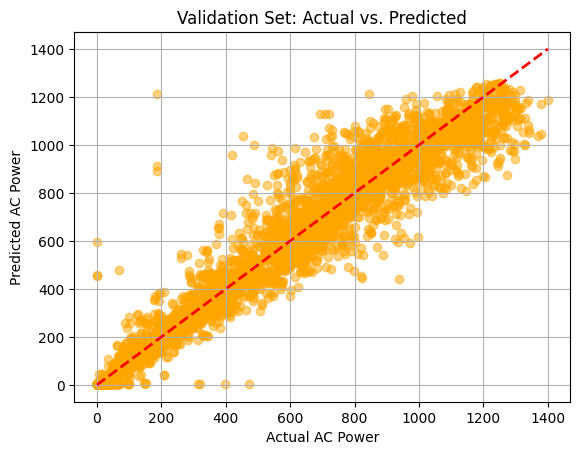

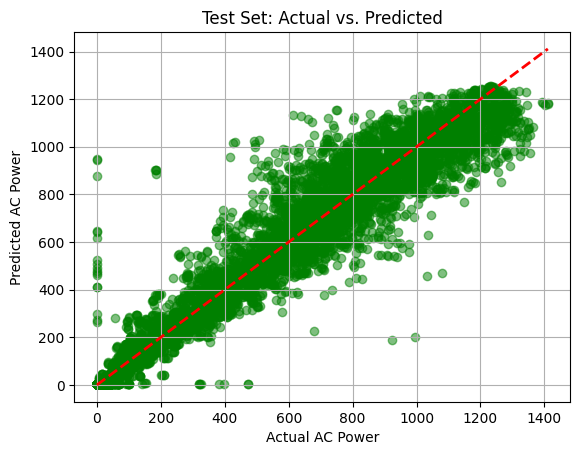

In [122]:
# Plot Validation Loss
plt.plot(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()

# Plot RSME error
plt.plot(figsize=(12,6))
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()

# Train Set Scatter Plot
plt.plot(figsize =(12,6))
plt.scatter(y_train_inversed, y_pred_train, alpha=0.5, s=10, color = 'blue') 
plt.plot([y_train_inversed.min(), y_train_inversed.max()], [y_train_inversed.min(), y_train_inversed.max()], 'r--', lw=2)
plt.title('Training Set: Actual vs. Predicted')
plt.xlabel('Actual AC Power')
plt.ylabel('Predicted AC Power')
plt.grid(True)
plt.legend()
plt.show()

# Validation Set Scatter Plot
plt.plot(figsize=(12,6))
plt.scatter(y_val_inversed, y_pred_val, alpha=0.5, color = 'orange')
plt.plot([y_val_inversed.min(), y_val_inversed.max()], [y_val_inversed.min(), y_val_inversed.max()], 'r--', lw=2)
plt.title('Validation Set: Actual vs. Predicted')
plt.xlabel('Actual AC Power')
plt.ylabel('Predicted AC Power')
plt.grid(True)
plt.show()

# Test Set Scatter Plot
plt.plot(figsize=(12,6))
plt.scatter(y_test_inversed, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test_inversed.min(), y_test_inversed.max()], [y_test_inversed.min(), y_test_inversed.max()], 'r--', lw=2)
plt.title('Test Set: Actual vs. Predicted')
plt.xlabel('Actual AC Power')
plt.ylabel('Predicted AC Power')
plt.grid(True)
plt.show()

In [123]:
# Save the model
model.save("Plant1_inverter_Model_V2.keras")

In [ ]:
# Load the trained model
model = tf.keras.models.load_model("Plant1_inverter_Model_V2.keras")

# Check the model architecture
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 24, 32)         │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,021 (101.65 KB)

 Trainable params: 8,673 (33.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,348 (67.77 KB)

In [110]:
# Save history
import pickle
with open("history_inverter_model_plant_2.pkl", "wb") as f:
    pickle.dump(history.history, f)


In [98]:
with open("history.pkl", "rb") as f:
    history = pickle.load(f)